### O Corpus:
O corpus principal consiste em dados de listening events de diversos usuários extraídos da plataforma Last.fm. [link](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html)

Para análise nesse trabalho, foi escolhido, dentre os usuários da América Latina, 2 usuários brasileiros para que seus hábitos de consumo musical fossem analisados.

Com os listening events desses usuários, foi realizada uma consulta, com o nome do artista e o nome da música, na plataforma Genius para ter acesso às letras dessas músicas. [script_get_lyrics](https://https://drive.google.com/file/d/1T0BZbM56XaOwK93DTjxxaCEpK1e--5gU/view?usp=drive_link)

Algumas das músicas dos registros não obtiveram resultado nas buscas das letras, então foram desconsideradas.

Essas letras foram pré-processadas, mantendo somente às em inglês e português para facilitar a análise dessas letras, uma vez que constituiam a maioria do corpus inicial dos usuários brasileiros.


## Setup

In [ ]:
!pip install langdetect
!pip install spacy
!pip install contractions
!pip install spacy_spanish_lemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=7022614ef5781ba4863b3d173bbb8cee955499733c97fd2ffcf79002221b1816
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/index_com

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download pt_core_news_sm
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 40.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 82.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from langdetect import detect

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

import spacy
import spacy_spanish_lemmatizer
import contractions
import string
from wordcloud import WordCloud

from textblob import TextBlob

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.decomposition import PCA

import re

ModuleNotFoundError: No module named 'langdetect'

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive_path = 'drive/My Drive/PLN/Trab1/'
content = f'/content/{drive_path}'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carrega as letras

In [ ]:
part_1 = pd.read_csv(f'{content}/lyrics/lyrics_part_1.csv', delimiter=',', on_bad_lines='skip')
part_2 = pd.read_csv(f'{content}/lyrics/lyrics_part_2.csv', delimiter=',', on_bad_lines='skip')
retry = pd.read_csv(f'{content}/lyrics/lyrics_retry.csv', delimiter=',', on_bad_lines='skip')

In [ ]:
df_concat = pd.concat([part_1, part_2, retry], ignore_index=True)
df_unique = df_concat.drop_duplicates(subset='trackid', keep='first').reset_index(drop=True)

### Limpa o dataset de letras que não estão corretas

In [ ]:
track_id_info_df = pd.read_csv(f'{content}/lyrics/track_id_info.csv', delimiter=',', on_bad_lines='skip')

In [ ]:
track_id_info = {}
for index, row in track_id_info_df.iterrows():
  track_id_info[row['index']] = {
      'trackname': row['trackname'],
      'artistname': row['artistname'],
      'artistid': row['artistid']
  }

In [ ]:
def normalize_text(text):
  text = text.lower().strip().replace("’", "").replace("'", "").replace("&", "and").replace(" ", "")
  text = ' '.join(re.sub(r'\([^)]*\)', '', text).split())

  return text

In [ ]:
def extract_first_line(text):
  first_line = text.splitlines()[0] if text else ""
  return first_line.replace(" ", "").lower()

def check_first_line_contains_title(str1, str2):
  str1 = normalize_text(str1)
  str2 = normalize_text(str2)

  if len(str2) == 0: return True
  for index, value in enumerate(str1):
    if value == str2[0] and str1[index:index+len(str2)] == value: return True

  return False

def is_true(row):
  first_line = extract_first_line(row['lyric'])
  trackname = track_id_info[row['trackid']]['trackname']

  return check_first_line_contains_title(first_line, trackname)

In [ ]:
df_unique = df_unique[~df_unique.apply(is_true, axis=1)]

In [ ]:
len(df_unique)

39007

## Processando as letras

As letras são obtidas por web scraping pela lib que acessa a plataforma Genius. Dessa forma, não trazem as letras filtradas, contendo informações que não fazem parte das letras.

In [ ]:
def remove_contributor_transalations_embed(text):
  begin = (text.rfind("Lyrics") + len("Lyrics"))
  end = (text.rfind("Embed"))
  while text[end - 1].isdigit():
    end = end - 1

  return text[begin:end].replace("You might also like", "")

In [ ]:
lyrics = {}

In [ ]:
for index, row in df_unique.dropna().iterrows():
  lyrics[row['trackid']] = remove_contributor_transalations_embed(row['lyric'])

In [ ]:
print(len(lyrics))

39007


## tokenizacao das musicas

In [ ]:
def safe_detect_language(text):
  try:
    if len(text.strip()) < 10:
      return "unknown"
    return detect(text)
  except Exception:
    return "unknown"

In [ ]:
all_lyrics = '\n'.join(list(lyrics.values())).lower()

char_tokens = list(all_lyrics.replace('\n', ''))
word_tokens = word_tokenize(all_lyrics)
paragraphs = [p for p in all_lyrics.split('\n') if p]
sentence_tokens = [sent_tokenize(par) for par in paragraphs]
sentence_tokens = [sent[0] for sent in sentence_tokens if sent]

detected_languages = [safe_detect_language(lyric) for lyric in lyrics.values()]

char_freq = Counter(char_tokens)
word_freq = Counter(word_tokens)
sentence_leng_freq = Counter([len(word_tokenize(sent)) for sent in sentence_tokens])
language_distribution = Counter(detected_languages).most_common(20)

char_freq_top = char_freq.most_common(20)
word_freq_top = word_freq.most_common(20)
sentence_leng_freq_top = sentence_leng_freq.most_common(20)

KeyboardInterrupt: 

In [ ]:
language_distribution

In [ ]:
def plot_distribution(data, title, xlabel):
  plt.figure(figsize=(10, 6))
  values = [value for key, value in data]
  keys = [key for key, value in data]
  plt.bar(keys, values, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Frequência')
  plt.xticks(keys, rotation=90)
  plt.tight_layout()
  plt.show()

plot_distribution(char_freq_top, "Distribuição de caracteres (top 20)", "Caracteres")
plot_distribution(word_freq_top, "Distribuição de palavras (top 20)", "Palavras")
plot_distribution(sentence_leng_freq_top, "Distribuição de tamanho de sentenças (top 20)", "Número de palavras por sentença")
plot_distribution(language_distribution, "Distribuição de idiomas das letras", "Idiomas")

In [ ]:
def get_top_k_n_grams(corpus, k):
  tokens = word_tokenize(corpus)
  unigrams = tokens

  bigrams = list(ngrams(tokens, 2))

  unigrams_count = Counter(unigrams)
  bigrams_count = Counter(bigrams)

  top_k_unigrams = unigrams_count.most_common(k);
  top_k_bigrams = bigrams_count.most_common(k);

  return top_k_unigrams, top_k_bigrams

def plot_top_k_unigrams_bigrams(unigrams, bigrams):
  unigram_labels, unigram_counts = zip(*unigrams)
  bigram_labels, bigram_counts = zip(*bigrams)
  bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

  fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

  axes[0].bar(unigram_labels, unigram_counts, color='skyblue')
  axes[0].set_title('Top-k Unigrams')
  axes[0].set_xlabel('Unigrams')
  axes[0].set_ylabel('Counts')
  axes[0].tick_params(axis='x', rotation=45)

  axes[1].bar(bigram_labels, bigram_counts, color='lightgreen')
  axes[1].set_title('Top-k Bigrams')
  axes[1].set_xlabel('Bigrams')
  axes[1].set_ylabel('Counts')
  axes[1].tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

unigrams, bigrams = get_top_k_n_grams(all_lyrics, 10)
plot_top_k_unigrams_bigrams(unigrams, bigrams)

## salvando corpus pre processamento

In [ ]:
data = [[key, value] for key, value in lyrics.items()]
corpus_df = pd.DataFrame(data, columns=["trackid", "lyric"])
corpus_df = corpus_df.dropna()
corpus_df.to_csv(f'{drive_path}/lyrics/corpus pre process.csv', index=False)

with open(f'{drive_path}/lyrics/corpus pre process.txt', "w", encoding="utf-8") as file:
    file.write('\n'.join(corpus_df['lyric'].str.lower()))

## pre processamento dos dados

In [ ]:
lyrics = {}
lyrics_df = pd.read_csv(f'{content}/lyrics/corpus pre process.csv', delimiter=',', on_bad_lines='skip')
for index, row in lyrics_df.iterrows():
  lyrics[row['trackid']] = row['lyric']

### stopwords

In [ ]:
lang_dict_code = {
  "pt": "portuguese",
  "en": "english",
  "es": "spanish"
}

lang_dict_name = {
  "portuguese": "pt",
  "english": "en",
  "spanish": "es"
}

In [ ]:
lyrics_lang = {}

In [ ]:
def remove_stopwords(text, language):
  stop_words = set(stopwords.words(language))

  text_cleaned = ''.join([char for char in text if char not in string.punctuation])
  text_cleaned = ' '.join([word for word in text_cleaned.split() if word.lower() not in stop_words])

  tokens = word_tokenize(text_cleaned.lower())

  filtered_tokens = [
    word for word in tokens if word not in stop_words and word not in string.punctuation
  ]

  if language == "english":
    expanded_words = []
    for word in filtered_tokens:
      expanded_words.append(contractions.fix(word))
    filtered_tokens = expanded_words

  return ' '.join(filtered_tokens)

lyrics_stopwords = {}

for key, lyric in lyrics.items():
  detected_lang = safe_detect_language(lyric)
  if detected_lang not in lang_dict_code: continue

  language = lang_dict_code[detected_lang]
  lyrics_lang[key] = language
  lyrics_stopwords[key] = remove_stopwords(lyric, language).lower()

In [ ]:
len(lyrics_stopwords)

37180

### lematizacao

Foi escolhido a lematizacao ao inves do stemming porque mantém mais informações coerentes das músicas. Considerando o contexto artistico e subjetivo, essa caracteristica será de grande importancia.

A biblioteca Spacy foi utilizada porque oferece suporte tanto a língua portuguesa quanto a lingua inglesa.


In [ ]:
nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")
nlp_es = spacy.load("es_core_news_sm")

def lemmatize_lyric(key, lyric):
    if lyrics_lang[key] == "english":
        doc = nlp_en(lyric)
    elif lyrics_lang[key] == "portuguese":
        doc = nlp_pt(lyric)
    elif lyrics_lang[key] == "spanish":
        doc = nlp_es(lyric)

    return " ".join([token.lemma_ for token in doc]).replace("  ", " ")

lyrics_stopwords_lemmatization = {}

for key, lyric in lyrics_stopwords.items():
    lyrics_stopwords_lemmatization[key] = lemmatize_lyric(key, lyric)


In [ ]:
len(lyrics_stopwords_lemmatization)

37180

## salvando corpus pos processamento

In [ ]:
data = [[key, value] for key, value in lyrics_stopwords_lemmatization.items() if value and pd.notna(value)]
corpus_df = pd.DataFrame(data, columns=["track_uri", "lyric"])

corpus_df.to_csv(f'{drive_path}/lyrics/corpus.csv', index=False)

In [ ]:
corpus_df = pd.read_csv(f'/content/drive/My Drive/PLN/Trab1/lyrics/corpus.csv', delimiter=',')
corpus_dict = {}
for index, row in corpus_df.iterrows():
  corpus_dict[row['track_uri']] = row['lyric']

In [ ]:
len(corpus_dict)

In [ ]:
corpus = '\n'.join(list(corpus_dict.values())).lower()

In [ ]:
with open(f'{drive_path}/lyrics/corpus.txt', "w", encoding="utf-8") as file:
    file.write(corpus)

## analisando corpus pos processamento

In [ ]:
char_tokens = list(corpus.replace('\n', ''))
word_tokens = word_tokenize(corpus)
paragraphs = [p for p in corpus.split('\n') if p]

char_freq = Counter(char_tokens)
word_freq = Counter(word_tokens)

char_freq_top = char_freq.most_common(20)
word_freq_top = word_freq.most_common(20)


In [ ]:
def plot_distribution(data, title, xlabel):
  plt.figure(figsize=(10, 6))
  values = [value for key, value in data]
  keys = [key for key, value in data]
  plt.bar(keys, values, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Frequência')
  plt.xticks(keys, rotation=90)
  plt.tight_layout()
  plt.show()

plot_distribution(char_freq_top, "Distribuição de caracteres (top 20)", "Caracteres")
plot_distribution(word_freq_top, "Distribuição de palavras (top 20)", "Palavras")

In [ ]:
def get_top_k_n_grams(corpus, k):
  tokens = word_tokenize(corpus)
  unigrams = tokens

  bigrams = list(ngrams(tokens, 2))

  unigrams_count = Counter(unigrams)
  bigrams_count = Counter(bigrams)

  top_k_unigrams = unigrams_count.most_common(k);
  top_k_bigrams = bigrams_count.most_common(k);

  return top_k_unigrams, top_k_bigrams

def plot_top_k_unigrams_bigrams(unigrams, bigrams):
  unigram_labels, unigram_counts = zip(*unigrams)
  bigram_labels, bigram_counts = zip(*bigrams)
  bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

  fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

  axes[0].bar(unigram_labels, unigram_counts, color='skyblue')
  axes[0].set_title('Top-k Unigrams')
  axes[0].set_xlabel('Unigrams')
  axes[0].set_ylabel('Counts')
  axes[0].tick_params(axis='x', rotation=45)

  axes[1].bar(bigram_labels, bigram_counts, color='lightgreen')
  axes[1].set_title('Top-k Bigrams')
  axes[1].set_xlabel('Bigrams')
  axes[1].set_ylabel('Counts')
  axes[1].tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

unigrams, bigrams = get_top_k_n_grams(corpus, 10)
plot_top_k_unigrams_bigrams(unigrams, bigrams)

## word cloud

Percebesse que as palavras em inglês dominam a word cloud, uma vez que o corpus é majoritariamente composto por letras nessa lingua.
Palavras interessante que estão com grande destaque na word cloud que serão analisadas mais tarde são know e love, também outras que tem grande significado e ganham destaque sao say, see, time, make, want, never, entre outras.

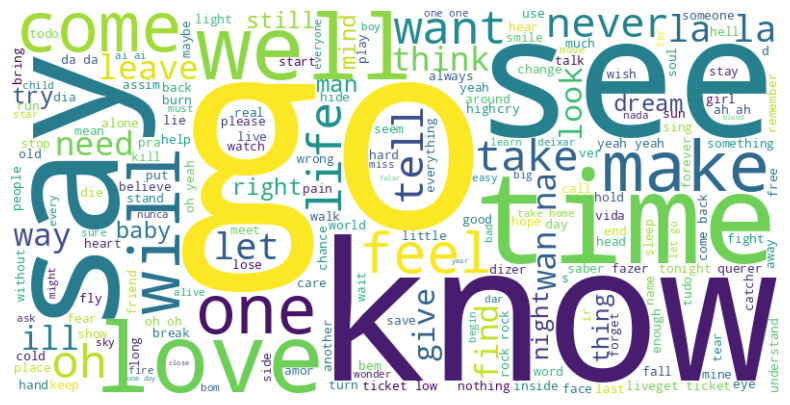

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

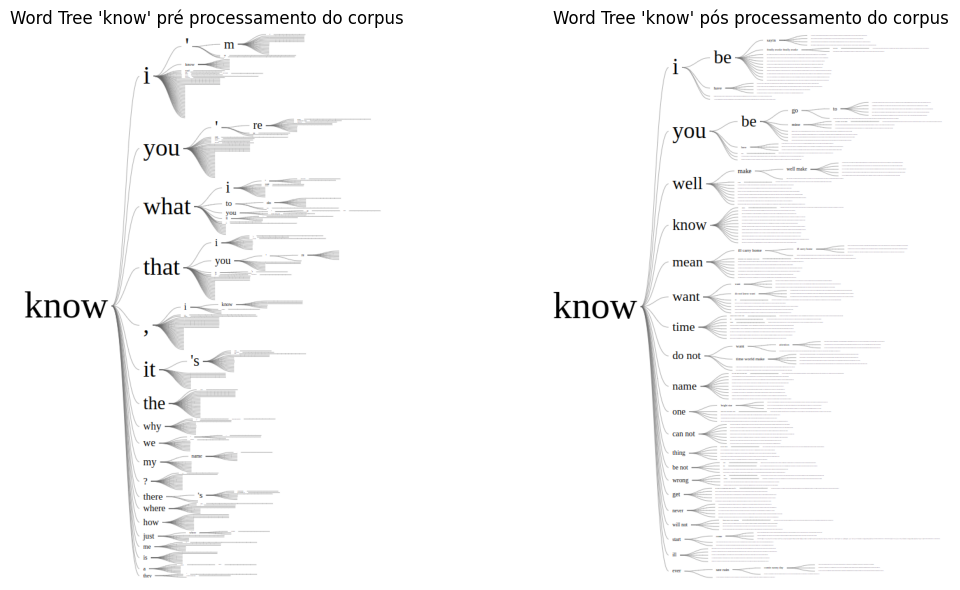

In [ ]:
img1 = mpimg.imread(f'/content/drive/My Drive/PLN/Trab1/know_pre_process.png')
img2 = mpimg.imread(f'/content/drive/My Drive/PLN/Trab1/know_pos_process.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].set_title("Word Tree 'know' pré processamento do corpus")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Word Tree 'know' pós processamento do corpus")
axes[1].axis('off')

plt.tight_layout()
plt.show()

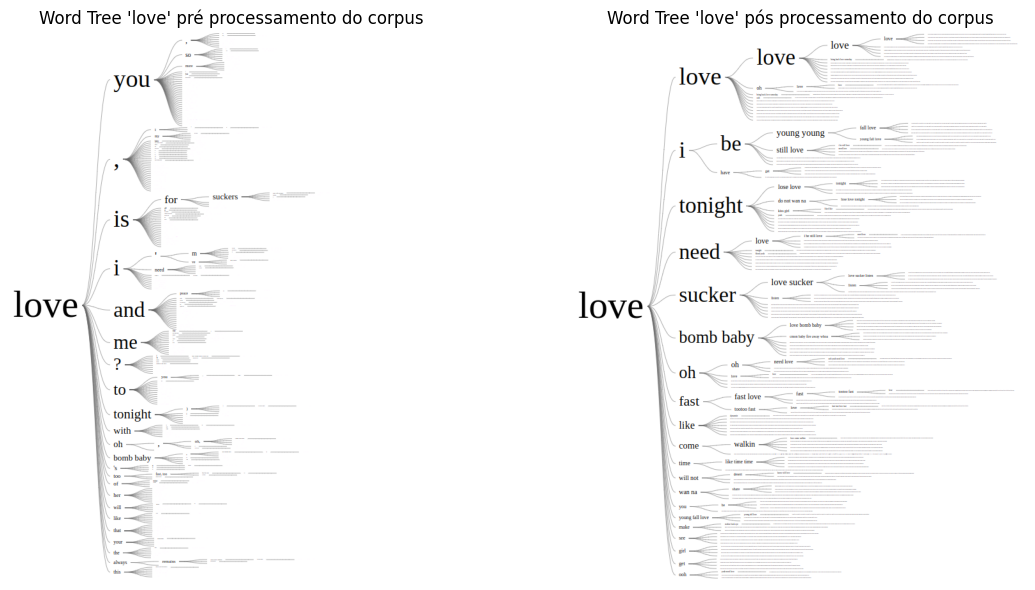

In [ ]:
img1 = mpimg.imread(f'/content/drive/My Drive/PLN/Trab1/love_pre_process.png')
img2 = mpimg.imread(f'/content/drive/My Drive/PLN/Trab1/love_pos_process.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].set_title("Word Tree 'love' pré processamento do corpus")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Word Tree 'love' pós processamento do corpus")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## analise de sentimentos

A maioria do corpus teve como resultado um sentimento positivo, seguido por negativo e por fim neutro.
Porém, como pode ser observado no gráfico de polaridade x subjetividade, o corpus como um todo ocupou um espaço mais central no gráfico. Sendo assim, concluímos que o corpus não é extremo em relação à polaridade e subjetividade, sendo considerado mais neutro.

In [ ]:
def analyze_sentiments(corpus):
  results = []
  blob = TextBlob(corpus)
  polarity = blob.sentiment.polarity
  subjectivity = blob.sentiment.subjectivity

  sentiment = "Neutral"
  if polarity > 0:
    sentiment = "Positive"
  elif polarity < 0:
    sentiment = "Negative"

  results = {
    "polarity": polarity,
    "subjectivity": subjectivity,
    "sentiment": sentiment
  }
  return results

In [ ]:
analysis = analyze_sentiments(corpus)

print("Análise de sentimentos do corpus inteiro:")
print(f"Polarity: {analysis['polarity']:.2f}, Subjectivity: {analysis['subjectivity']:.2f}, Sentiment: {analysis['sentiment']}")

Análise de sentimentos do corpus inteiro:
Polarity: 0.06, Subjectivity: 0.52, Sentiment: Positive


In [ ]:
sentiment_by_lyrics = {}
polarity_by_lyrics = {}
subjectivity_by_lyrics = {}

for track_uri, lyric in corpus_dict.items():
  analysis = analyze_sentiments(lyric)
  sentiment_by_lyrics[track_uri] = analysis['sentiment']
  polarity_by_lyrics[track_uri] = analysis['polarity']
  subjectivity_by_lyrics[track_uri] = analysis['subjectivity']

In [ ]:
sentiment_by_lyrics_top = Counter(sentiment_by_lyrics.values()).most_common()

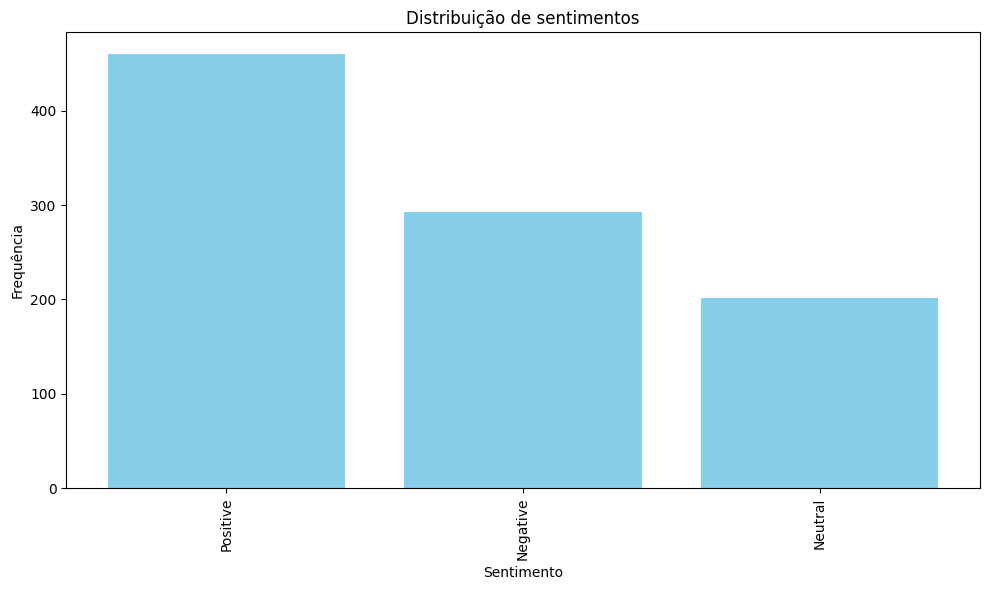

In [ ]:
def plot_distribution(data, title, xlabel):
  plt.figure(figsize=(10, 6))
  values = [value for key, value in data]
  keys = [key for key, value in data]
  plt.bar(keys, values, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Frequência')
  plt.xticks(keys, rotation=90)
  plt.tight_layout()
  plt.show()

plot_distribution(sentiment_by_lyrics_top, "Distribuição de sentimentos", "Sentimento")

## plot polarity x subjectivity


*   **polarity**: Um valor entre -1 e 1 que indica o sentimento. Valores negativos indicam sentimentos negativos, positivos indicam positivos e valores próximos de 0 indicam neutralidade.

*   **subjectivity**: Um valor entre 0 e 1 que indica a subjetividade, mais próximo de 1 significa que a frase é uma opinião, mais próximo de 0 indica um fato.


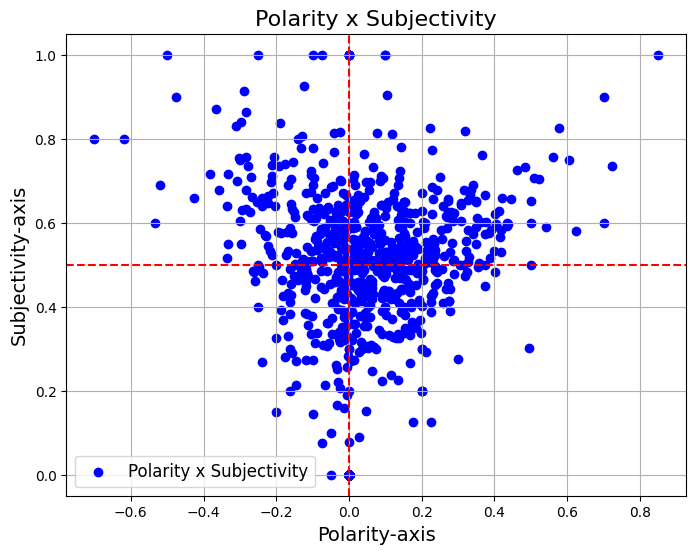

In [ ]:
polarity = polarity_by_lyrics.values()
subjectivity = subjectivity_by_lyrics.values()

plt.figure(figsize=(8, 6))
plt.scatter(polarity, subjectivity, marker='o', color='b', label='Polarity x Subjectivity')

plt.axhline(y=0.5, color='red', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')

plt.title("Polarity x Subjectivity", fontsize=16)
plt.xlabel("Polarity-axis", fontsize=14)
plt.ylabel("Subjectivity-axis", fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)

plt.show()

## vetorizacao do corpus

O método escolhido paa a vetorização do corpus foi a Word2Vec uma vez que trabalhos semelhantes na área utilizaram o mesmo algoritmo para estudar corpus de músicas e gostos dos usuários e playlists.

In [ ]:
tokenized_lyrics = [simple_preprocess(lyric) for lyric in corpus_dict.values()]
model = Word2Vec(sentences=tokenized_lyrics, vector_size=100, window=5, min_count=1, workers=4)

model.save("music_lyrics_word2vec.model")

model = Word2Vec.load("music_lyrics_word2vec.model")

vocab = list(model.wv.index_to_key)
print(f"Vocabulary: {vocab}")
print(f"Vocabulary size: {len(vocab)}")

NameError: name 'simple_preprocess' is not defined

In [ ]:
word = "love"
similar_words = model.wv.most_similar(word, topn=10)

print(f"Top 10 palavras similares a '{word}':")
for similar_word, similarity_score in similar_words:
  print(f"{similar_word}: {similarity_score}")


Top 10 palavras similares a 'love':
tonight: 0.9796236157417297
really: 0.9755288362503052
need: 0.9736235737800598
anymore: 0.9702434539794922
like: 0.9694570302963257
girl: 0.968591034412384
let: 0.9684245586395264
little: 0.9659743905067444
hollaback: 0.9636833667755127
hear: 0.96349036693573


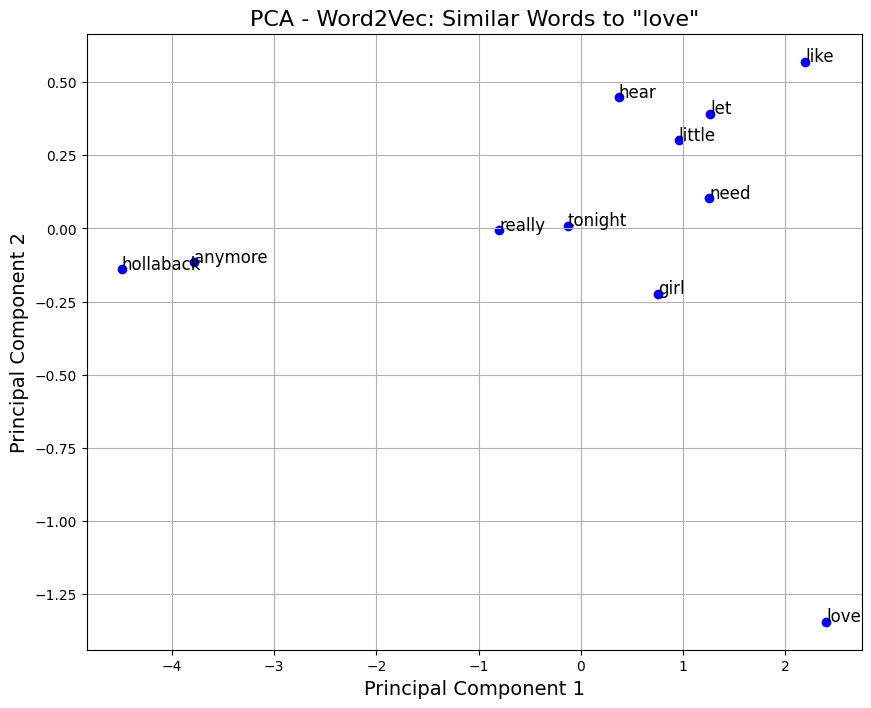

In [ ]:
similar_words = model.wv.most_similar(word, topn=10)

words = [word] + [similar_word for similar_word, _ in similar_words]
vectors = [model.wv[word]] + [model.wv[similar_word] for similar_word, _ in similar_words]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='blue')

for i, value in enumerate(words):
  plt.annotate(value, (pca_result[i, 0], pca_result[i, 1]), fontsize=12)

plt.title(f'PCA - Word2Vec: Similar Words to "{word}"', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True)
plt.show()


# Segunda Parte

Nessa etapa vamos analisar o corpus de letras de mais países da America Latina, para entendermos um pouco mais sobre sua diversidade e propor um recomendador baseado em similaridade das musicas para analisar o nivel de diversidade.

## Setup 2

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA

In [ ]:
drive_path = 'drive/My Drive/PLN/Trab1/'
content = f'/content/{drive_path}'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lyrics Embedding

We will use models that consider the sequencial aspect of the lyrics, like BERT

In [ ]:
corpus_df = pd.read_csv(f'/content/drive/My Drive/PLN/Trab1/lyrics/corpus.csv', delimiter=',')
corpus_dict = {}
for index, row in corpus_df.iterrows():
  corpus_dict[row['track_uri']] = row['lyric']

### BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import pickle

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Process corpus
embeddings = {}
for song_id, lyrics in tqdm(corpus_dict.items()):
    processed_lyrics = " ".join(simple_preprocess(lyrics))
    embeddings[song_id] = get_bert_embedding(processed_lyrics, model, tokenizer)

# Save embeddings
with open("music_lyrics_bert.pkl", "wb") as f:
    pickle.dump(embeddings, f)

# Load embeddings
with open("music_lyrics_bert.pkl", "rb") as f:
    embeddings = pickle.load(f)

print(f"Number of embedded songs: {len(embeddings)}")
print(f"Embedding dimension: {list(embeddings.values())[0].shape}")

KeyboardInterrupt: 

### Word2Vec

In [ ]:
tokenized_lyrics = [simple_preprocess(lyric) for lyric in corpus_dict.values()]
model = Word2Vec(sentences=tokenized_lyrics, vector_size=100, window=5, min_count=1, workers=4)

model.save("music_lyrics_word2vec.model")

model = Word2Vec.load("music_lyrics_word2vec.model")

vocab = list(model.wv.index_to_key)
print(f"Vocabulary: {vocab}")
print(f"Vocabulary size: {len(vocab)}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# tokenized_lyrics = [simple_preprocess(lyric) for lyric in corpus_dict.values()]
# model = Word2Vec(sentences=tokenized_lyrics, vector_size=100, window=5, min_count=1, workers=4)

# model.save(f'/content/drive/My Drive/PLN/Trab1/models/music_lyrics_word2vec.model')

model = Word2Vec.load(f'/content/drive/My Drive/PLN/Trab1/models/music_lyrics_word2vec.model')

vocab = list(model.wv.index_to_key)
print(f"Vocabulary: {vocab}")
print(f"Vocabulary size: {len(vocab)}")

Vocabulary: ['be', 'not', 'get', 'go', 'do', 'know', 'you', 'love', 'oh', 'see', 'come', 'like', 'time', 'say', 'one', 'yeah', 'take', 'have', 'make', 'well', 'never', 'want', 'feel', 'will', 'to', 'can', 'way', 'let', 'baby', 'life', 'away', 'day', 'back', 'we', 'ill', 'tell', 'think', 'look', 'night', 'give', 'could', 'man', 'would', 'eye', 'na', 'because', 'need', 'world', 'leave', 'right', 'heart', 'thing', 'find', 'there', 'good', 'keep', 'live', 'mind', 'try', 'fall', 'hey', 'die', 'wan', 'little', 'girl', 'hear', 'long', 'run', 'around', 'dream', 'turn', 'light', 'lie', 'low', 'that', 'hand', 'nothing', 'she', 'lose', 'call', 'head', 'still', 'they', 'home', 'break', 'hold', 'always', 'ir', 'wait', 'every', 'la', 'ticket', 'face', 'end', 'liveget', 'ever', 'walk', 'stand', 'cry', 'ooh', 'inside', 'something', 'burn', 'another', 'soul', 'place', 'people', 'tonight', 'boy', 'much', 'kill', 'old', 'alone', 'everything', 'believe', 'stop', 'new', 'god', 'friend', 'fire', 'rock', 'pl

In [ ]:
def get_average_vector(tokens, model):
  vectors = [model.wv[word] for word in tokens if word in model.wv]
  if vectors:
    return np.mean(vectors, axis=0)  # Média dos vetores
  else:
    return np.zeros(model.vector_size)

In [ ]:
track_word2vec = {}

In [ ]:
data = []
for track_id, lyric in corpus_dict.items():
    tokens = simple_preprocess(lyric)
    vector = get_average_vector(tokens, model)
    track_word2vec[track_id] = vector
    row = {'track_id': track_id}
    row.update({f'vector_{i}': value for i, value in enumerate(vector)})
    data.append(row)

df = pd.DataFrame(data)

In [ ]:
df.to_csv(f'{drive_path}/lyrics/track_word2vec.csv', index=False)

In [ ]:
track_word2vec['ae3c90fc-d26f-4b5c-b66f-d38094f918a0']

## Separando os listening events em sessoes

In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
listening_events_brazil = pd.read_csv(f'{content}/listening events/listening_events_brazil.csv', delimiter=',', on_bad_lines='skip')
listening_events_brazil['timestamp'] = pd.to_datetime(listening_events_brazil['timestamp'])
listening_events_brazil = listening_events_brazil.sort_values(by=['userid', 'timestamp'])

In [ ]:
track_id_info = {}
for index, row in listening_events_brazil.iterrows():
  if row['trackid'] in track_id_info: continue
  track_id_info[row['trackid']] = {
      'trackname': row['trackname'],
      'artistname': row['artistname'],
      'artistid': row['artistid']
  }

In [ ]:
pd.DataFrame.from_dict(track_id_info, orient='index').reset_index().to_csv(f'{drive_path}/lyrics/track_id_info.csv', index=False)

In [ ]:
len(listening_events_brazil)

423898

In [ ]:
listening_events_by_user = {}
for index, row in listening_events_brazil.iterrows():
  if row['userid'] not in listening_events_by_user: listening_events_by_user[row['userid']] = []
  listening_events_by_user[row['userid']].append(row.to_dict())

In [ ]:
from datetime import timedelta

listening_events_by_user_sessions = {}
def split_by_timestamp(data, threshold_minutes=20):
  result = []
  current_group = [data[0]]

  for i in range(1, len(data)):
    time_diff = data[i]['timestamp'] - data[i - 1]['timestamp']
    if time_diff > timedelta(minutes=threshold_minutes):
      result.append(current_group)
      current_group = []
    current_group.append(data[i])

  if current_group:
    result.append(current_group)

  return result

for index, value in listening_events_by_user.items():
  listening_events_by_user_sessions[index] = split_by_timestamp(value, threshold_minutes=20)

In [ ]:
listening_events_by_user_sessions_dataset = []
for userid, sessions in listening_events_by_user_sessions.items():
  for idx_session, session in enumerate(sessions):
    for idx_track, track in enumerate(session):
      row = track
      row['session'] = idx_session + 1
      row['track'] = idx_track + 1
      listening_events_by_user_sessions_dataset.append(row)

listening_events_by_user_sessions_dataset_df = pd.DataFrame(listening_events_by_user_sessions_dataset)
listening_events_by_user_sessions_dataset_df.to_csv(f'{drive_path}/sessions/listening_events_by_user_sessions_dataset.csv', index=False)

In [ ]:
listening_events_by_user_sessions_dataset_df.head()

,userid,timestamp,artistid,artistname,trackid,trackname,session,track
0,user_000034,2005-09-15 21:05:03+00:00,fe3503fb-146f-4d68-a591-a7e5798c321f,Afrika Bambaataa,8e025002-e43c-41df-8581-e737c84e33cc,Zulu Nation Throwdown,1,1
1,user_000034,2005-09-15 21:18:12+00:00,fe3503fb-146f-4d68-a591-a7e5798c321f,Afrika Bambaataa,d081e710-a4cf-43df-9916-3800d7c6d093,Jazzy Sensation (Bronx Version),1,2
2,user_000034,2005-09-15 21:27:51+00:00,fe3503fb-146f-4d68-a591-a7e5798c321f,Afrika Bambaataa,19f25ddb-77f7-4484-879d-e69665a5dda8,Planet Rock,1,3
3,user_000034,2005-09-16 13:30:04+00:00,db612997-f11e-424d-8b41-cf410a433656,Asian Dub Foundation,65699429-f33b-4fa1-be57-76887305cbdc,Memory War,2,1
4,user_000034,2005-09-16 13:33:27+00:00,db612997-f11e-424d-8b41-cf410a433656,Asian Dub Foundation,e2c3ed94-97fb-4869-9dab-4c653b632eb7,Officer Xx,2,2


### Carregando sessoes e tracks de cada usuário

In [ ]:
listening_events_by_user_sessions_dataset_df = pd.read_csv(f'{content}/sessions/listening_events_by_user_sessions_dataset.csv', delimiter=',', on_bad_lines='skip')

In [ ]:
listening_events_by_user_sessions = {}

for _, row in listening_events_by_user_sessions_dataset_df.iterrows():
    userid = row['userid']
    session = int(row['session'])
    track_data = row.drop(['userid', 'session', 'track']).to_dict()

    if userid not in listening_events_by_user_sessions:
        listening_events_by_user_sessions[userid] = []

    while len(listening_events_by_user_sessions[userid]) < session:
        listening_events_by_user_sessions[userid].append([])

    listening_events_by_user_sessions[userid][session - 1].append(track_data)

### Processando word2vec de cada sessao

In [ ]:
track_word2vec_df = pd.read_csv(f'{content}/lyrics/track_word2vec.csv', delimiter=',', on_bad_lines='skip')
track_word2vec = {}

for _, row in track_word2vec_df.iterrows():
    track_id = row['track_id']
    vector = row.filter(like='vector_').to_numpy()
    track_word2vec[track_id] = vector

In [ ]:
listening_events_by_user_sessions_word2vec = {}
session_tracks = {}
user_sessions = {}
session_id = 0
for userid, sessions in listening_events_by_user_sessions.items():
  listening_events_by_user_sessions_word2vec[userid] = []
  for session in sessions:
    listening_events_by_user_sessions_word2vec[userid].append([])
    for event in session:
      word2vec = np.zeros(100)
      if event['trackid'] in track_word2vec:
        if session_id not in session_tracks: session_tracks[session_id] = []
        session_tracks[session_id].append(event['trackid'])
        word2vec = track_word2vec[event['trackid']]
        listening_events_by_user_sessions_word2vec[userid][-1].append(word2vec)
    if userid not in user_sessions: user_sessions[userid] = []
    user_sessions[userid].append(session_id)
    session_id += 1

In [ ]:
import json
with open(f'{drive_path}/sessions/sessions_tracks.json', "w") as json_file:
    json.dump(session_tracks, json_file, indent=4)

In [ ]:
import json
with open(f'{drive_path}/sessions/user_sessions.json', "w") as json_file:
    json.dump(user_sessions, json_file, indent=4)

In [ ]:
session_tracks

{0: ['8e025002-e43c-41df-8581-e737c84e33cc',
  'd081e710-a4cf-43df-9916-3800d7c6d093',
  '19f25ddb-77f7-4484-879d-e69665a5dda8'],
 1: ['65699429-f33b-4fa1-be57-76887305cbdc',
  'e2c3ed94-97fb-4869-9dab-4c653b632eb7',
  '745b8bb1-e3b0-4b10-8ad6-32affd886de1',
  'f0d08ee6-caa2-42e2-a6c4-6b0074839b84',
  'e2c133e6-712d-45b4-bb0b-581ffa79481d',
  'e22ee971-59ba-4066-a79c-82af3a250104',
  '054d2ea0-5e79-4634-b810-e2497bffcacb',
  'b827c90f-dc5a-459f-977d-cd97ea69dab5',
  '6ac35358-05dd-494c-ba3c-0a48f83cf77f',
  '672396a0-e474-4619-8cb1-625e83b1631a',
  'd97174c6-dd10-43e3-86b5-385cd06ae4ad',
  '669e2cfd-b787-4fb9-9b25-352aac854e82',
  '2b998231-bb49-4a07-af3d-aad85dbd36c4',
  '648f48b9-6d95-4c2f-a5eb-88798d5e2992',
  '582664ad-e1b7-47b1-b95e-1a8e175d63e0',
  '6fbbc720-4391-48ab-8bc6-bf2353b394db',
  'eb495e44-1ae1-42c0-b792-573ed08ee043',
  '74cbeb16-e9c7-4aef-9630-aa9225088c4d',
  'c0cb15cf-ab15-4eb3-9e5a-a64109559a09',
  '69fdafdd-d6dc-4649-b6b2-c353bfeff6d9',
  'eda6d20c-c831-46db-b01c-

In [ ]:
len(session_tracks.keys())

23095

In [ ]:
sessions_word2vec_by_user = {}

for userid, sessions in listening_events_by_user_sessions_word2vec.items():
  sessions_word2vec_by_user[userid] = []

  for session in sessions:
    if isinstance(session, list) and len(session) > 0:
      session_array = np.array(session)

      session_mean = np.mean(session_array, axis=0)

      sessions_word2vec_by_user[userid].append(session_mean)


In [ ]:
sessions_by_user = {}
sessions = np.concatenate(list(sessions_word2vec_by_user.values()), axis=0)
session_id = 0
for userid, sessions in sessions_word2vec_by_user.items():
  if userid not in sessions_by_user: sessions_by_user[userid] = []
  for session_vector in sessions:
    sessions_by_user[userid].append(session_id)
    session_id += 1

In [ ]:
len(sessions)

23095

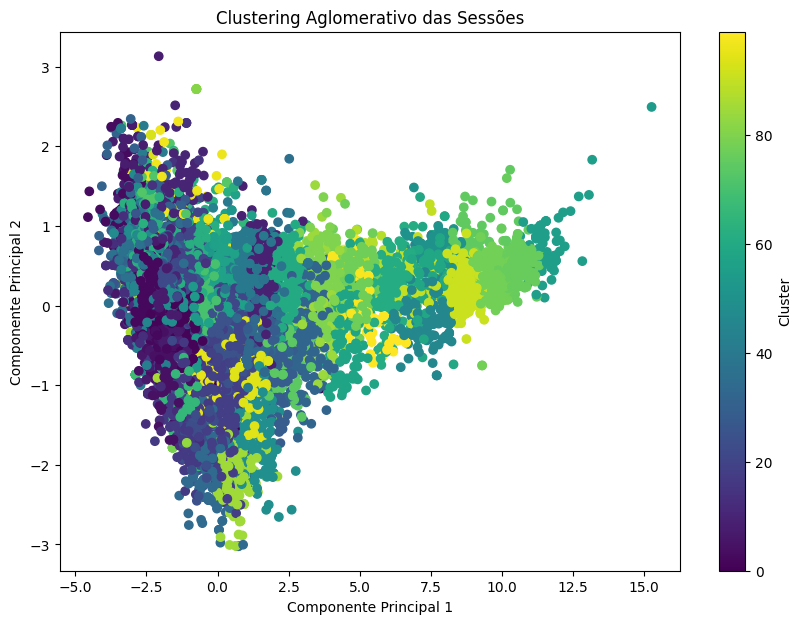

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

sessions = np.array(sessions)

n_clusters = 100
model = AgglomerativeClustering(n_clusters=n_clusters)
model.fit(sessions)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(sessions)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=model.labels_, cmap='viridis', marker='o')
plt.title('Clustering Aglomerativo das Sessões')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
session_clusters = {index: cluster for index, cluster in enumerate(model.labels_)}


In [ ]:
len(session_clusters)

23095

In [ ]:
session_dict = {index: value for index, value in enumerate(session)}

In [ ]:
session_id = 0
sessions_word2vec_by_user_dict = {}
for userid, sessions in sessions_word2vec_by_user.items():
  if userid not in sessions_word2vec_by_user_dict: sessions_word2vec_by_user_dict[userid] = []
  sessions_word2vec_by_user_dict[userid].append(session_id)
  session_id += 1

In [ ]:
session_dict[0] == list(sessions_word2vec_by_user_dict.values())[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
clusters_grouped = {}
for session, cluster in session_clusters.items():
  if cluster not in clusters_grouped:
    clusters_grouped[cluster] = []
  clusters_grouped[cluster].append(session)

In [ ]:
size_each_cluster = {}
total = 0
for cluster, sessions in clusters_grouped.items():
  size_each_cluster[cluster] = len(sessions)
  total += len(sessions)